# Some Basic Statistics

Some basic functions for variance using numpy and scipy.

By the end of this file you should have seen simple examples of:
1. Mean, standard deviation and variance
2. Confidence intervals
3. One-way analysis of variance (ANOVA)
4. Student's T-test
5. F-test
6. Coefficient of determination
7. Pearson's correlation coefficient
8. Probability Distribution Functions (PDFs)

Further Reading:  
https://docs.scipy.org/doc/scipy/reference/stats.html  
https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
https://github.com/scipy/scipy/blob/master/scipy/stats/stats.py  
http://www.itl.nist.gov/div898/handbook/eda/section3/eda3672.htm   
http://www.physics.csbsju.edu/stats/t-test.html  
https://onlinecourses.science.psu.edu/stat501/node/255  
http://originlab.com/doc/Origin-Help/ANOVA-CRD  
http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-22.html  

In [1]:
import numpy as np
from numpy.random import normal, rand
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

### Mean, Standard Deviation and Variance

These all give an initial sense of the distribution of numbers - where they are centered (mean) and how spread out they are (standard deviation and variance). 

Keep in mind that the variance is the square of the standard deviation.

In [2]:
nums = normal(2,3,1000)

We can do these calculations manually:

In [3]:
mean = (1/len(nums))*np.sum(nums)
print('The mean is: %g' % mean)

stdev = np.sqrt(1/len(nums) * np.sum((nums - mean)**2))
print('The standard deviation (all samples, or the population) is: %g' % stdev)

stdev = np.sqrt(1/(len(nums)-1) * np.sum((nums - mean)**2))
print('The unbiased standard deviation (a group of samples, or a subset of the population) is: %g' % stdev)

var = (1/len(nums)) * np.sum((nums - mean)**2)
print('The variance is: %g' % var)

The mean is: 2.01594
The standard deviation (all samples, or the population) is: 3.03999
The unbiased standard deviation (a group of samples, or a subset of the population) is: 3.04151
The variance is: 9.24151


Or by using built-in functions:

In [4]:
mean = np.mean(nums)
print('The mean is: %g' % mean)

stdev = np.std(nums)
print('The standard deviation (all samples, or the population) is: %g' % stdev)

stdev = np.std(nums, ddof=1)
print('The standard deviation (a group of samples, or a subset of the population) is: %g' % stdev)

var = np.var(nums)
print('The variance is: %g' % var)

The mean is: 2.01594
The standard deviation (all samples, or the population) is: 3.03999
The standard deviation (a group of samples, or a subset of the population) is: 3.04151
The variance is: 9.24151


## Confidence Intervals

How sure are we that the measurements we've taken encompass the average value? Confidence intervals can be used to communicate this point.

Starting with a normally distributed set samples, we want to state with a known amount of confidence if the mean falls within the interval reported using that set of samples. 

We report:  
$\mu \pm \sigma_m T$  

where:  
$\mu$ is the mean value  
$T$ is the critical probability (t-value)  
$\sigma_m = \frac{\sigma}{\sqrt{n}}$  is the standard error of the mean  
$\sigma$ is the standard deviation  
$n$ is the number of samples    

Notes:  
  - Technically, the true definition of a confidence interval (using 95% confidence as an example) is more accurately summarized by the following:  
  
    **A confidence interval of 95% means that the confidence interval, if repeated with many different groups of samples, would encompass the true value 95% of the time.** This is a slight distinction: it's not that there is a 95% chance that the value is within that particular confidence interval - it's a statement that the confidence interval, if repeated, would trend towards encompassing the true value 95% of the time.  
    

  - Because we're assuming that it's a subset of the population, we're concerned with the critical probability determined with the t-distribution instead of the normal distribution. This is more accurate for lower sampling because it takes into account the degrees of freedom. Keep in mind the T- and the normal distributions converge for large sampling. 
  
  
  - For more information about the critical probability, see the 'Confidence Intervals from a Distribution Perspective' section near the end of this notebook. 

In [5]:
# Start with normally distributed group of samples
grp1 = normal(100,5,10000)

In [6]:
# Compute the standard error of the mean
grp1_avg = np.mean(grp1)
grp1_std = np.std(grp1, ddof=1)
standard_err = grp1_std/np.sqrt(np.size(grp1))

#Determine the critical probability that corresponds to 1/2 of the 95% confidence interval (see Distributions)
conf_int = 0.95
dof = len(grp1)-1 # We use the degrees of freedom of n-1 because it's a sample of the population
T_val = stats.t.ppf(1-(1-conf_int)/2, dof) 

# The average value, reported with 95% confidence is:
conf_int = T_val*standard_err
lower_int = grp1_avg - T_val*standard_err
upper_int = grp1_avg + T_val*standard_err

print("The value is %0.3g ± %0.3g (95%% confidence interval)" % ( grp1_avg, conf_int))
print("or a range of %0.6g to %0.6g" % ( lower_int,upper_int ))

The value is 100 ± 0.0986 (95% confidence interval)
or a range of 99.8867 to 100.084


We can also use the built in function for determining the 95% confidence interval:

In [7]:
lower_int, upper_int = stats.t.interval(0.95, len(grp1)-1, loc=np.mean(grp1), scale=stats.sem(grp1))
print("A range of %0.6g to %0.6g" % (lower_int, upper_int))

A range of 99.8867 to 100.084


## One-Way Analysis of Variance ANOVA 

Here, we're looking to determine multiple groups of samples are from the same population or from different populations, using a single factor (independent variable) that affects the mean value of the group.

Keep in mind that the samples should be continuous and independent.

### Two groups: Student's T-test

**The goal of the Student's t-test is to determine if one group of samples actually comes from a different population than another group of samples, or if they are both from the same population.** This comes up frequently when we want to determine if the data we're collected somehow differs from another data set (i.e. we've observed something change, or observe something different from what someone else claims). 

**To do this, first calculate a t-value, and use this t-value (to sample the t-distribution) to determine a measure of how similar the two groups of samples are (aka, p-value).** 

**A p-value below some threshold (i.e. 0.05) means that there is a significant difference between the groups of samples.** The p-value represents the chance that the difference between the groups of samples is observed purely by chance. As the t-value increases, the p-value decreases (decreasing chances that the samples are from the same distribution). 

Often, this is described in terms of the null hypothesis, or the claim that there is 'null difference' between the two groups of samples. In other words, can the null hypothesis (there is no difference between the two populations) be rejected? The goal is to determine if any difference is due to sampling, experimental, etc. error or if the means really are different.

This is intended for normally distributed, continuous distributions.

Fun fact: the 'student' is actually William S. Gossett, a brewmaster who worked at the Guinness brewery. 

In [8]:
from scipy.stats import ttest_ind, ttest_rel

In [9]:
# Three similar groups of data
grp1 = normal(45,23,5)
grp2 = normal(45,23,5)
grp3 = normal(10,12,5)

This can be done by hand, integrating the student t-distribution cumulative density fuction directly. Z-tables, tables of precalculated cumulate density function values, may also be used but aren't discussed here. Below, the survival function (`stats.t(degFreedom).sf`, or '1 - cumulant density function') is used to sample the t-distribution. 

#### Equal sample sizes, equal variances
$t = \frac{\bar{X}_1 - \bar{X}_2}{s_{pool}\sqrt{\frac{2}{n}}}$  
where:  
$s_{pool} = \sqrt{\frac{s_1^2 + s_2^2}{2}}$


$n$ is the number of samples  
$\bar{X}$ is the expectation value  
$s_1^2 = \frac{1}{n-1} \sum^{n}_{1} (x_i-\bar{X})^2$ 


#### Equal or unequal sample sizes, equal variances  
$t = \frac{\bar{X}_1 - \bar{X}_2}{s_{pool}\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$  
where:  
$s_{pool} = \sqrt{\frac{(n_1 -1) s_1^2 + (n_2 -1) s_2^2}{n_1 + n_2 -1}}$

#### Equal or unequal sample sizes, unequal variances
$t = \frac{\bar{X}_1 - \bar{X}_2}{s_\delta}$  
where:  
$s_\delta = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$  
 
 
 

In [10]:
grp1_siz = grp1.size
grp1_dof = grp1_siz - 1
grp1_avg = np.sum(grp1)/grp1_siz
grp1_var = 1/(grp1_dof)* np.sum((grp1 - grp1_avg)**2)

grp2_siz = grp2.size
grp2_dof = grp2_siz - 1
grp2_avg = np.sum(grp2)/grp2_siz
grp2_var = 1/(grp2_dof)* np.sum((grp2 - grp2_avg)**2)

grp3_siz = np.size(grp3)
grp3_avg = np.sum(grp3)/grp3_siz
grp3_dof = grp3_siz - 1
grp3_var = 1/(grp3_dof)* np.sum((grp3 - grp3_avg)**2)

# Calculate the student's T and p values: 

# Equal sample size, assumed equal variance:
pooled_var = np.sqrt( (grp1_var + grp2_var)/2)
t = (grp1_avg - grp2_avg)/(pooled_var*np.sqrt(2/grp1.size))

# Calculate P value:
degFreedom = (grp1_var/grp1_siz + grp2_var/grp2_siz)**2/((grp1_var/grp1_siz)**2/grp1_dof + (grp2_var/grp2_siz)**2/grp2_dof)
p = 2*stats.t(degFreedom).sf(np.abs(t)) #we want 2x the area under the curve from neg infinity to the neg t value
print(" t = %g p = %g" % (t, p) )

# Equal or unequal sample size, assumed equal variance:
pooled_var = np.sqrt( (grp1_dof*grp1_var+grp2_dof*grp2_var)/(grp1_siz+grp2_siz-2) )
t = (grp1_avg - grp2_avg)/(pooled_var*np.sqrt(1/grp1_siz + 1/grp2_siz))
# Calculate P value:
degFreedom = (grp1_var/grp1_siz + grp2_var/grp2_siz)**2/((grp1_var/grp1_siz)**2/grp1_dof + (grp2_var/grp2_siz)**2/grp2_dof)
p = 2*stats.t(degFreedom).sf(np.abs(t))
print(" t = %g p = %g" % (t, p))

# Equal or unequal sample size, assumed unequal variance:
var = np.sqrt( grp1_var/grp1_siz + grp3_var/grp3_siz )
t = (grp1_avg - grp3_avg)/var
# Calculate P value:
degFreedom = (grp1_var/grp1_siz + grp3_var/grp3_siz)**2/((grp1_var/grp1_siz)**2/grp1_dof + (grp3_var/grp3_siz)**2/grp3_dof)
p = 2*stats.t(degFreedom).sf(np.abs(t))
print(" t = %g p = %g" % (t, p))

 t = -0.422997 p = 0.685461
 t = -0.422997 p = 0.685461
 t = 4.19672 p = 0.0105073


Or use built-in functions:

In [11]:
# Equal sample size, assumed equal variance:
t, p = ttest_rel(grp1, grp2)
print("ttest_rel   eq_var: t = %g  p = %g" % (t, p))

# Equal or unequal sample size, assumed equal variance:
t, p = ttest_ind(grp1, grp2, equal_var=True)
print("ttest_ind   eq_var: t = %g  p = %g" % (t, p))

#Note that the first and second t-tests converge as sampling approaches infinity.

# Equal or unequal sample size, assumed unequal variance:
t, p = ttest_ind(grp1, grp3, equal_var=False)
print("ttest_ind uneq_var: t = %g  p = %g" % (t, p))

ttest_rel   eq_var: t = -0.441842  p = 0.68144
ttest_ind   eq_var: t = -0.422997  p = 0.683439
ttest_ind uneq_var: t = 4.19672  p = 0.0105073


If the p-value is smaller than the threshold (i.e. 0.01 or 0.05, etc.) then the null hypothesis can be rejected. Note that the first and second tests converge as sampling approaches infinity.

### >2 Groups: One-way ANOVA F-test statistic

The F-test can be thought of as the generalized form of the t-test for multiple groups of samples. **A popular use of the F-test is to determine if one group of samples actually comes from a different population than all other groups, or if all are from the same population.** While there are several different F-tests, the focus here is on a test to determine if the means of a given set of normally distributed values are equal. 

**To do this, first calculate a F-statistic, and use this F-statistic (to sample the F-distribution) to find the chance that all of the groups of samples are from the same population (aka, p-value).** 

**A p-value below some threshold (i.e. 0.05) means that there is a significant difference between the groups of samples.** The p-value represents the chance that the difference between the groups of samples is observed purely by chance. As the F-statistic (ratio of variation between sample means to the variation within the samples) increases, the p-value decreases (decreasing chances that the samples are from the same distribution).

Often, this is described in terms of the null hypothesis - or, the hypothesis that there is null difference between the groups of samples. In other words, can the null hypothesis (there is no difference between the populations) be rejected? The goal is to determine if any difference is due to sampling, experimental, etc. error or if the means really are different. 

This is intended for normally distributed, continuous distributions.

In [12]:
grp1 = normal(45,23,500)
grp2 = normal(45,23,500)
grp3 = normal(10,12,500)

Here, we use:

$F_{stat} = \frac{\text{between set variability}}{\text{within set variability}}$  

where:  
between set variability = $\sum^{K}_{i=1} \frac{n_i(\bar{X_i} -\bar{X})^2}{K - 1}$  
within set variability = $\sum^{K}_{i=1} \sum^{n_i}_{j=1} \frac{(X_{ij} -\bar{X_i})^2}{N - K}$  

and:  
$\bar{X}$ is the mean of all data  
$\bar{X_i}$ is the mean of set $i$  
$K$ is the number of sets  
$N$ is the overall sample size  

In [13]:
#import scipy.special as special
all_grps = [grp1, grp2, grp3]

num_grps = float(len(all_grps))
alldata = np.concatenate(all_grps)
alldata_avg = np.mean(alldata)
alldata_siz = np.size(alldata)

bsv = 0
for a in all_grps:
    bsv += (np.size(a)* (np.mean(a)-alldata_avg)**2)/(num_grps-1)

wsv = 0
for a in all_grps:
    for i in a:
        wsv += (i - np.mean(a))**2/(alldata_siz - num_grps)

f_stat = bsv/wsv

prob = stats.f(num_grps-1, alldata_siz-num_grps).sf(np.abs(f_stat))

print('F-statistic is %g p is %g' % (f_stat, prob))

F-statistic is 511.656 p is 4.62379e-170


In [14]:
f, p = stats.f_oneway(grp1,grp2,grp3)

print('F-statistic is %g p is %g' % (f, p))

F-statistic is 511.656 p is 4.62379e-170


### Coefficient of Determination ($R^2$)

**The coefficient of determination is a measure of how well one group of samples (i.e. measured ) matches another (i.e. the model).** This is accomplished via the propotion of total variation of outcomes explained by the model.

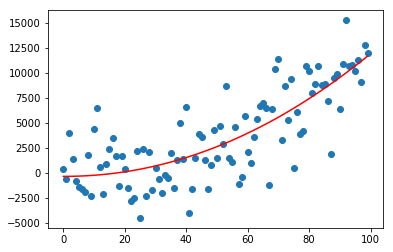

In [15]:
from scipy.optimize import curve_fit

# Create Arbitrary Function 
x_vals = np.arange(0,100)
y_vals = x_vals**2 + normal(0,3000,np.size(x_vals))

# Fit and create fit line
def func(x_vals, B, C):
    return x_vals**B + C
opt, cov = curve_fit(func, x_vals, y_vals)
x_fitted = np.linspace(0, max(x_vals), 100)
y_fitted = func(x_fitted, *opt)

# Show fit
plt.scatter(x_vals, y_vals)
plt.plot(x_fitted, y_fitted, color='red')
plt.show()

Compute by hand:


$R^2 = \frac{SS_{regr}}{SS_{total}}$  

where:  
$SS_{regr} = \sum^{n}_{1} (\hat{x_i}-\bar{X})^2$  
$SS_{total} = \sum^{n}_{1} (x_i-\bar{X})^2$  

and:  
$\hat{x_i}$ is the fitted value  
$\bar{X}$ is the average value of X  
$x_i$ is the measured value of x  

In [16]:
y_avg = np.mean(y_vals)
y_fit = func(x_vals, *opt)

SSregr  = np.sum( (y_fit  - y_avg )**2 )
SSerror = np.sum( (y_vals - y_fit )**2 )
SStotal = np.sum( (y_vals - y_avg )**2 )

Rsq = SSregr/SStotal
print('R squared is: %g' % Rsq)

R squared is: 0.63877


### Pearson's correlation coefficient

**For two sets of data, how correlated are the two, on a scale of -1 to 1?** A simple calculation is used to check if the two groups of samples are correlated. 

**A p-value for the Pearson's correlation coefficient can also be determined**, indicating the propability of an uncorrelated system producing data that has a Pearson correlation at least as extreme (not reliable for small groups of samples).

Keep in mind that the correlation coefficient is defined for sets of the same size.

In [17]:
from scipy.stats import pearsonr

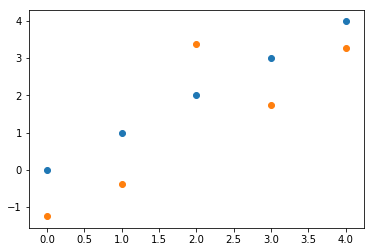

In [18]:
grp1 = list(range(0,5))
grp2 = grp1+normal(0,1,np.size(grp1))

plt.scatter(grp1, grp1)
plt.scatter(grp1, grp2)
plt.show()

Again we can do this by hand:

$\rho = \frac{ \sum^{n}_{1} (1/n) (X_1 - \bar{X}_1) (X_2 - \bar{X}_2)}{s_1^2 s_2^2}$  

The p value can be determined by converting $\rho$ to a student's t and then determining the area under the distribution function:

$t_{conv} = \frac{\rho}{\sqrt{( 1-\rho^2) / (n-2)}} $


In [19]:
grp1_siz = np.size(grp1)
grp1_avg = np.sum(grp1)/grp1_siz
grp1_std = np.sqrt((1/grp1_siz) * np.sum((grp1 - grp1_avg)**2)) 

grp2_siz = np.size(grp2)
grp2_avg = np.sum(grp2)/grp2_siz
grp2_std = np.sqrt((1/grp2_siz) * np.sum((grp2 - grp2_avg)**2)) 

dof = grp1_siz - 2


# Note that the size of the two samples must be the same
pearson_r = np.sum( 1/grp1_siz*(grp1 - grp1_avg)*(grp2 - grp2_avg) ) / (grp1_std * grp2_std)

t_conv = pearson_r/np.sqrt( (1 - pearson_r**2)/(grp1_siz - 2) ) # convert to student's t value
p = 2*stats.t(dof).sf(np.abs(t_conv))

print("pearson_r = %g  p = %g" % (pearson_r, p))

pearson_r = 0.83661  p = 0.0773094


Or use built in functions:

In [20]:
r,p = pearsonr(grp1,grp2)

print("pearson_r = %g  p = %g" % (r, p))

pearson_r = 0.83661  p = 0.0773094


### Distributions

**Distribution functions can be thought of as the probability of measuring the a particular sample value.** To get a better picture of how frequently a type of randomly distributed variable should be measured in theory, we can use the analytical distribution function. 

For example, perhaps the most well known distribution is the Gaussian, Normal, or Bell-Curve Distribution. This is from a set of gaussian distributed random numbers. We can generate a lot of these numbers and plot the frequency of each number within a set of 'bins':

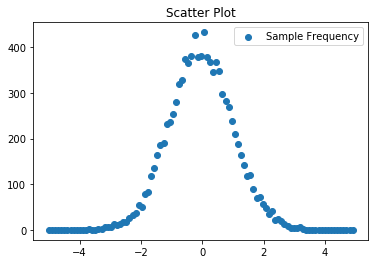

In [21]:
num_samples = 10000
span = 10
rand_gen = normal(0,1,num_samples)        # Generate num_sample numbers
bins = np.linspace(-span/2,span/2,num=100)
histogram = np.histogram(rand_gen,bins);  # Use histogram to get distribution

X = histogram[1][:-1]
Y = histogram[0]
plt.scatter(X,Y, label="Sample Frequency")
plt.legend(loc='best')
plt.title('Scatter Plot')
plt.show()

The probability distribution function (PDF), is a function that represents the probability of obtaining a particular value for a population that follows that particular distribution.  

Using a conversion factor, it's clear that the two overlap:

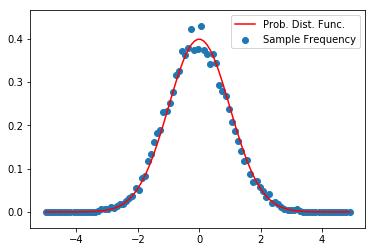

In [22]:
Y_pdf = stats.norm.pdf(X)                 # PDF function applied to the X values
conv_factor = len(X)/(span * num_samples) # Use a normalization factor to demonstrate the two are overlapped
plt.scatter(X,Y*conv_factor, label="Sample Frequency")
plt.plot(X,Y_pdf, color='red', label="Prob. Dist. Func.")
plt.legend(loc='best')
plt.show()

A common use of distributions is to determine the chance of measuring a value of at least some amount. Instead of looking at the probability of obtaining exactly a value, we can ask: what is the probability of obtaining somthing at least as large?

All we need is the integration of the PDF, known as the cumulative distribution function (CDF), as we're really looking for the area under the PDF up to a certain point.

Continuing our example:

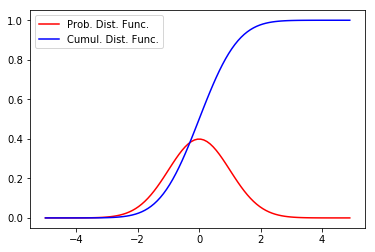

In [23]:
X_dof = np.size(X) - 1
Y_pdf = stats.norm.pdf(X) 
Y_cdf = stats.norm.cdf(X) 

plt.plot(X,Y_pdf, color='red', label="Prob. Dist. Func.")
plt.plot(X,Y_cdf, color='blue', label="Cumul. Dist. Func.")
plt.legend(loc='best')
plt.show()

For those that are wondering, the CDF is actually less than the PDF at a certain point because it's scaled such that the maximum value is one. Keep in mind the PDF is scaled such that the area beneath it is one. For more information, look into the integral of the PDF.

We use the CDF to determine the percent chance of obtaining something at least as large. I.e. what is the percent chance of getting at least 2?

In [24]:
stats.norm.cdf(2)

0.97724986805182079

### PDF of Students' T-distribution

This doesn't seem that interesting until we consider the distributions used in the ANOVA analysis. Here we use the student t-distribution, which is extremely similar to the normal distribution except that it incorporates the fact that we often use a subset of the population (and thus degrees of freedom = n-1) :

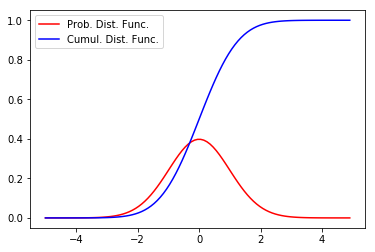

In [25]:
dof = np.size(X) - 1
Y_t_pdf = stats.t(dof).pdf(X)
Y_t_cdf = stats.t(dof).cdf(X) 

plt.plot(X, Y_t_pdf, color='red', label="Prob. Dist. Func.")
plt.plot(X, Y_t_cdf, color='blue', label="Cumul. Dist. Func.")
plt.legend(loc='best')
plt.show()

Let's say our t value is: -1.47254. For the p value of the t-test (two-tailed), we're concerned with getting the the value under the two sides of the distribution. Here we're ignoring the sign of the t value and treating it as a negative value for a zero-mean t-distribution probability distribution function.

For the two-tailed p value on a t-test:

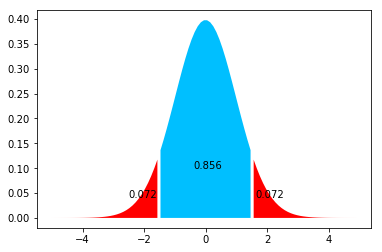

In [26]:
t = -1.47254

# Use CDF to determine probabilities
left_prob    = stats.t(dof).cdf(-np.abs(t))     
right_prob   = stats.t(dof).sf(np.abs(t)) # The survival function is 1-CDF
between_prob = 1-(left_prob+right_prob)

# Plot t-distribution, highlighting the different plot areas
left_ind    = X <= -np.abs(t)
right_ind   = X >= np.abs(t)
between_ind = (X > -np.abs(t)) & ( X < np.abs(t))

plt.fill_between(X[left_ind],stats.t(dof).pdf(X[left_ind]), facecolor='red')
plt.fill_between(X[right_ind],stats.t(dof).pdf(X[right_ind]), facecolor='red')
plt.fill_between(X[between_ind],stats.t(dof).pdf(X[between_ind]),facecolor='deepskyblue')

# Label the plot areas
plt.text(x=1.7*t,y=0.04, s='%0.3g' % left_prob)
plt.text(x=-0.4,y=0.1,s='%0.3g' % between_prob)
plt.text(x=1.1*-t,y=0.04, s='%0.3g' % right_prob)
plt.show()

The two-tailed test (i.e. including both sides) is simply 2x the value of the area of one of the sides:

In [27]:
p = 2*stats.t(dof).sf(np.abs(t))
print("%g" % p)

0.14408


## Confidence Intervals from a Distribution Perspective 

This is where the critical probability (t-value) for the confidence interval comes from. ** Working backwards, we're interested the value of the probability distribution function that, when sampled, encompasses $\frac{1}{2}$ of the confidence interval (i.e. 95%) area under the function.** 

To do so, 1/2 of the confidence interval on each side of the distribution is removed, and the corresponding t-value is determined.

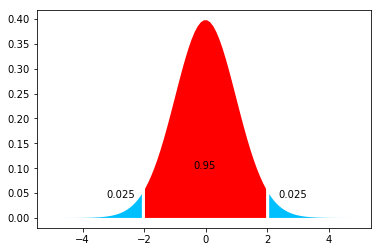

The t_value that can be used in the 95 percent confidence interval is: 1.9602


In [29]:
conf_int = 0.95  

# We use the t-distribution in lieu of the normal distribution because the samples are a subset of the population 
# the inverse of the CDF for the normal distribution is known as the percent point function
t_value = stats.t.ppf(1-(1-conf_int)/2,dof)

# Use CDF to check that probabilities are correct
left_prob    = stats.t.cdf(-t_value, dof)     
right_prob   = stats.t.sf(t_value, dof) # The survival function is 1-CDF
between_prob = 1-(left_prob+right_prob)

# Plot T distribution, highlighting the different plot areas
left_ind    = X <= -t_value
right_ind   = X >= t_value
between_ind = (X > -t_value) & ( X < t_value)

plt.fill_between(X[left_ind],stats.t.pdf(X[left_ind],dof), facecolor='deepskyblue')
plt.fill_between(X[right_ind],stats.t.pdf(X[right_ind],dof), facecolor='deepskyblue')
plt.fill_between(X[between_ind],stats.t.pdf(X[between_ind],dof),facecolor='red')

# Label the plot areas
plt.text(x=2.2*t,y=0.04, s='%0.3g' % left_prob)
plt.text(x=-0.4,y=0.1,s='%0.3g' % between_prob)
plt.text(x=1.6*-t,y=0.04, s='%0.3g' % right_prob)
plt.show()

print("The t_value that can be used in the 95 percent confidence interval is: %0.6g" % T_val)